In [2]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
df = web.DataReader('TSLA', data_source= 'yahoo', start='2010-06-29', end='2022-09-02')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,1.666667,1.169333,1.266667,1.592667,281494500.0,1.592667
2010-06-30,2.028000,1.553333,1.719333,1.588667,257806500.0,1.588667
2010-07-01,1.728000,1.351333,1.666667,1.464000,123282000.0,1.464000
2010-07-02,1.540000,1.247333,1.533333,1.280000,77097000.0,1.280000
2010-07-06,1.333333,1.055333,1.333333,1.074000,103003500.0,1.074000
...,...,...,...,...,...,...
2022-08-29,287.739990,280.700012,282.829987,284.820007,41864700.0,284.820007
2022-08-30,288.480011,272.649994,287.869995,277.700012,50541800.0,277.700012
2022-08-31,281.250000,271.809998,280.619995,275.609985,52107300.0,275.609985


In [4]:
df.shape

(3068, 6)

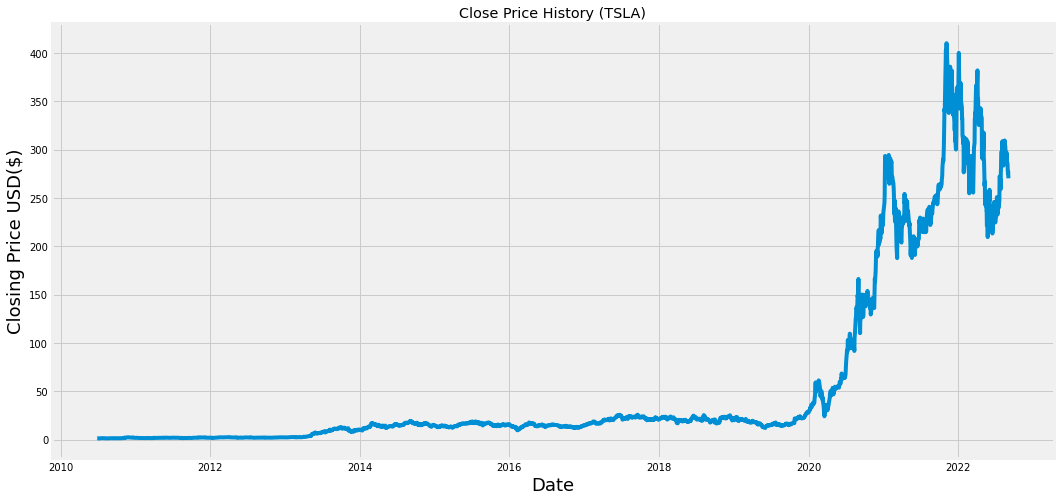

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History (TSLA)')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD($)', fontsize=18)
plt.show()

In [6]:
data = df.filter(['Close'])
# Convert into a numpy array
dataset = data.values
len_train_data = math.ceil(len(dataset) * 0.8)
len_train_data

2455

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00131893],
       [0.00130915],
       [0.00100428],
       ...,
       [0.67142446],
       [0.67521501],
       [0.65821885]])

In [8]:
train_data = scaled_data[0: len_train_data, :]
# Split into X_train and y_train
X_train = []
y_train = []

for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])


In [9]:
# Convert X_train and y_train into numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2395, 60, 1)

In [79]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(rate=0.3))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(rate=0.2))
model.add(Dense(25))
model.add(Dense(1))

In [86]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [87]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

2395/2395 [==============================] - 150s 60ms/step - loss: 8.0536e-05


In [88]:
test_data = scaled_data[len_train_data - 60: , :]

X_test = []
y_test = dataset[len_train_data:, :]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i, 0])

In [89]:
#Convert data into numpy array
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [90]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions

20/20 [==============================] - 3s 39ms/step


array([[ 34.267063],
       [ 35.761887],
       [ 36.932854],
       [ 37.55115 ],
       [ 37.692432],
       [ 37.608433],
       [ 37.558327],
       [ 37.654846],
       [ 37.997993],
       [ 38.85184 ],
       [ 40.402027],
       [ 42.5841  ],
       [ 45.190556],
       [ 47.946804],
       [ 50.53503 ],
       [ 52.49438 ],
       [ 53.830254],
       [ 54.500977],
       [ 54.663322],
       [ 54.75387 ],
       [ 54.847977],
       [ 55.08914 ],
       [ 55.42379 ],
       [ 55.49119 ],
       [ 55.423733],
       [ 55.33629 ],
       [ 55.341908],
       [ 55.4602  ],
       [ 55.82075 ],
       [ 56.378742],
       [ 57.040306],
       [ 57.641365],
       [ 58.142757],
       [ 58.506718],
       [ 58.78128 ],
       [ 58.968025],
       [ 59.103558],
       [ 59.251114],
       [ 59.385223],
       [ 59.498383],
       [ 59.590923],
       [ 59.608154],
       [ 59.653465],
       [ 60.000603],
       [ 60.618427],
       [ 61.41161 ],
       [ 62.191795],
       [ 62.9

In [91]:
# Calculate RMSE and MAPE
rmse = np.sqrt(np.mean(predictions - y_test)** 2)
mape = np.mean(np.abs((predictions - y_test)/y_test))*100
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))
print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))

Root Mean Squared Error (RMSE): 27.55
Mean Absolute Percentage Error (MAPE): 11.62%


C:\Users\William\AppData\Local\Temp\ipykernel_24804\1182801711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


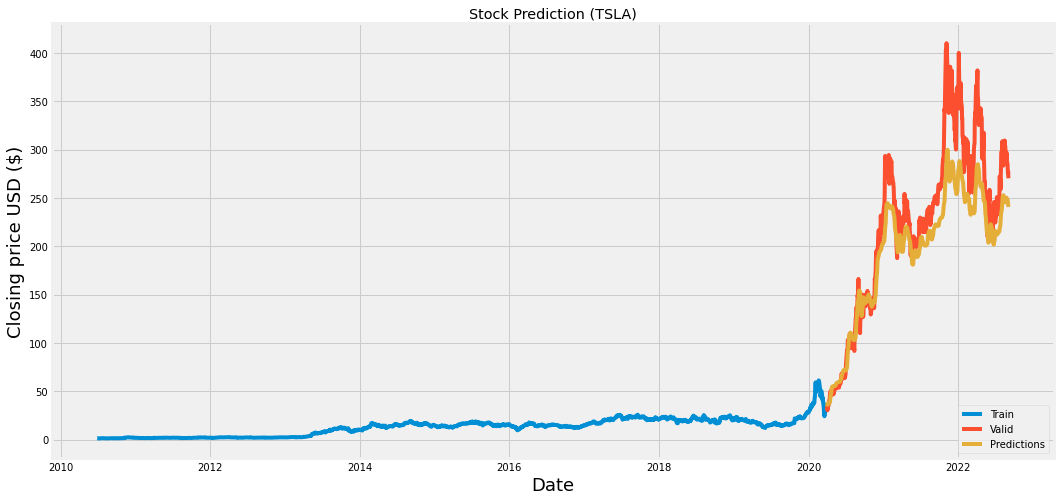

In [92]:
# Plot result
train = data[:len_train_data]
valid = data[len_train_data:]
valid['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Stock Prediction (TSLA)')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()